In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import datetime
import calendar
from geopy.geocoders import Nominatim
from staticmap import StaticMap, CircleMarker, Line
import overpy

## Fonctions

In [2]:
def find_insee(city, postal):
    insee = pd.read_csv('./../data/code_insee.csv', sep = ';')
    code = insee[(insee['Commune'] == city.upper()) & (insee['Code Postal'] == str(postal))].values
    assert len(code) > 0, "Aucune commune ne correspond à cette recherche"
    if len(code) > 1:
        for line in code:
            print(line[2:5])
        choice = int(input("Choisissez celui que vous voulez (entre 1 et " + str(len(code)) + ", autre pour annuler)"))
        if choice not in set(range(1,len(code))):
            print("Fonction annulée")
            return 0
        code = code[choice - 1][0]
    else:
        code = code[0][0]
    return code

In [3]:
def get_meteo(city, day):
    code = find_insee(city)
    if code == 0:
        return 0
    lieu_type = 'VILLE_FRANCE'
    
    url = "http://www.meteofrance.com/climat/meteo-date-passee?lieuId=" + code + "0&lieuType=" + lieu_type + "&date=" + day
    
    page = requests.get(url)
    assert page.status_code == 200, "Error loading the webpage"
    
    today = datetime.date.today()
    day = datetime.datetime.strptime(day, '%d-%m-%Y').date()
    limite = datetime.datetime.strptime('01-01-1963', '%d-%m-%Y').date()
    assert day < today and day > limite, "Wrong date (Need between 01-01-1963 and " + datetime.date.today().strftime('%d-%m-%Y') + ")"
    
    soup = BeautifulSoup(page.content, 'html.parser')
    liste_info_journee = soup.find_all('ul', class_='grid-half')
#     liste_horaires = soup.find_all('div', class_="grid-half echeances")
    
    if liste_info_journee:
        liste_info_journee = liste_info_journee[0].find_all('li')
#     if liste_horaires:
#         liste_horaires = liste_horaires[0].find_all('dl')
    
    res = liste_info_journee # + liste_horaires
#     for i in res:
#         print(i.get_text().strip())
    dic = {}
    for result in res:
        kv = result.get_text().split(':')
        key = kv[0].strip()
        value = kv[1].strip()
        tokeep = ''
        for i in value:
            if i.isdigit() or i == '.':
                tokeep += i
        dic[key] = float(tokeep)
    return dic

In [4]:
def get_meteo_monthly(city, month, year):
    nb_days = calendar.monthrange(year, month)[1]
    mean_d = {}
    list_min_temp = []
    list_max_temp = []
    list_soleil = []
    list_pluie = []
    for day in range(1, nb_days + 1):
        date = str(day) + '-' + str(month) + '-' + str(year)
        d = get_meteo(city, date)
        
        list_min_temp.append(d['Température minimale de la journée'])
        list_max_temp.append(d['Température maximale de la journée'])
        list_soleil.append(d["Durée d'ensoleillement de la journée"])
        list_pluie.append(d['Hauteur des précipitations'])
        
    mean_d['Température maximale du mois'] = max(list_max_temp)
    mean_d['Température minimale du mois'] = min(list_min_temp)
    mean_d['Température minimale moyenne'] = sum(list_min_temp) / len(list_min_temp)
    mean_d['Température maximale moyenne'] = sum(list_max_temp) / len(list_max_temp)

    mean_d['Hauteur minimale des précipitations'] = min(list_pluie)
    mean_d['Hauteur maximale des précipitations'] = max(list_pluie)
    mean_d['Hauteur moyenne des précipitations'] = sum(list_pluie) / len(list_pluie)
    
    mean_d["Durée maximale d'ensoleillement"] = max(list_soleil)
    mean_d["Durée minimale d'ensoleillement"] = min(list_soleil)
    mean_d["Durée d'ensoleillement moyenne"] = sum(list_soleil) / len(list_soleil)

    return mean_d

In [5]:
def get_city(lat, lon):
    nominatim = Nominatim(user_agent = 'my-application')
    r = nominatim.reverse(str(lat) + ',' + str(lon))
    return r.raw['address']

In [21]:
def get_plan(lat, lon):
    coord = (lon, lat)
    m = StaticMap(200, 400, url_template = "http://c.tiles.wmflabs.org/osm-no-labels/{z}/{x}/{y}.png")
    marker = CircleMarker(coord, 'red', 5) #longitude, latitude
    m.add_marker(marker)
    return m

In [7]:
def search_around(lat, lon, tag, dist):
    api = overpy.Overpass()
    q = """
        (
        node(around:{0},{1},{2})["{3}"];
        way(around:{0},{1},{2})["{3}"];
        rel(around:{0},{1},{2})["{3}"];
        );
        out;
        """
    q = q.format(dist, lat, lon, tag)
    r = api.query(q)
    return r

In [6]:
get_meteo('Toulouse', '07-05-2019')

{'Température minimale de la journée': 4.7,
 'Température maximale de la journée': 22.3,
 "Durée d'ensoleillement de la journée": 7.0,
 'Hauteur des précipitations': 0.4}

In [7]:
get_meteo_monthly('toulouse', 10, 2006)

{'Température maximale du mois': 26.2,
 'Température minimale du mois': 7.0,
 'Température minimale moyenne': 13.764516129032259,
 'Température maximale moyenne': 21.603225806451615,
 'Hauteur minimale des précipitations': 0.0,
 'Hauteur maximale des précipitations': 68.6,
 'Hauteur moyenne des précipitations': 2.8064516129032264,
 "Durée maximale d'ensoleillement": 11.0,
 "Durée minimale d'ensoleillement": 0.0,
 "Durée d'ensoleillement moyenne": 5.161290322580645}

In [8]:
get_city(47.47, 0.5)

{'place': "Rond de l'Âne",
 'village': 'Ambillou',
 'municipality': 'Chinon',
 'county': 'Indre-et-Loire',
 'state': 'Centre-Val de Loire',
 'country': 'France',
 'postcode': '37340',
 'country_code': 'fr'}

In [13]:
find_insee('Ambillou', '37340')

'37002'

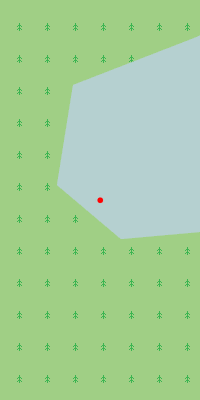

In [22]:
get_plan(47.47, 0.5).render(zoom = 20)

In [17]:
a = search_around(47.47, 0.5, "natural", 100)

In [18]:
for i in a.ways:
    print(i.tags)

{'natural': 'water'}
{'natural': 'water'}
